# Домашнее задание №1 - Метод К-ближайших соседей (K-neariest neighbors)

Сегодня мы с вами реализуем наш первый алгоритм машинного обучения, метод К-ближайших соседей. Мы попытаемся решить с помощью него задачи:
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)
- регрессии (когда зависимая переменная - натуральное число)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, то нам нужно научиться подбирать этот параметр. Мы постараемся научиться пользовать numpy для векторизованных вычислений, а также посмотрим на несколько метрик, которые используются в задачах классификации и регрессии.

Перед выполнением задания:
- установите все необходимые библиотеки, запустив `pip install -r requirements.txt`

Если вы раньше не работали с numpy или позабыли его, то можно вспомнить здесь:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd


from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from knn import KNNClassifier
from metrics import binary_classification_metrics, multiclass_accuracy, mse, mae, r_squared
from sklearn.metrics import confusion_matrix

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

## Задание 1. KNN на датасете Fashion-MNIST (10 баллов)

В этом задании вам предстоит поработать с картинками одежды, среди которых можно выделить 10 классов. Данные уже загружены за вас: в переменной X лежат 70000 картинок размером 28 на 28 пикселей, вытянутые в вектор размерностью 784 (28 * 28). Так как данных довольно много, а наш KNN будет весьма медленный, то возьмем случайно 1000 наблюдений (в реальности в зависимости от вашей реализации можно будет взять больше, но если будет не зватать ОЗУ, то берите меньше).

In [3]:
X, y = fetch_openml(name="Fashion-MNIST", return_X_y=True, as_frame=False)

In [4]:
idx_to_stay = np.random.choice(np.arange(X.shape[0]), replace=False, size=1000)
X = X[idx_to_stay]
y = y[idx_to_stay]

Давайте посмотрим на какое-нибудь изображение из наших данных:

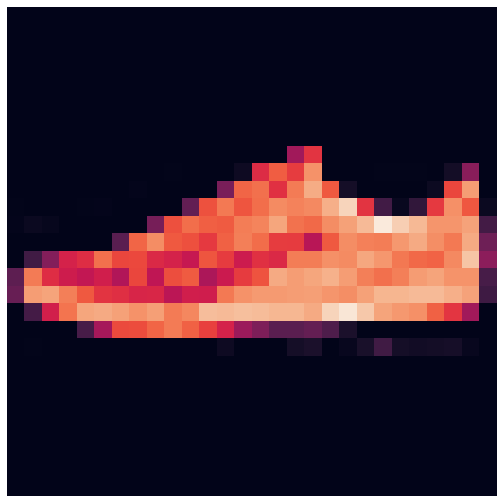

In [5]:
# возьмем случайную картинку и сделаем reshape
# 28, 28, 1 = H, W, C (число каналов, в данном случае 1)
image = X[np.random.choice(np.arange(X.shape[0]))].reshape(28, 28, 1)
plt.imshow(image)
plt.axis("off");

### 1.1. Посмотрим на все классы (0.5 баллов)

Возьмите по одной картинке каждого класса и изобразите их (например, сделайте subplots 5 на 2).

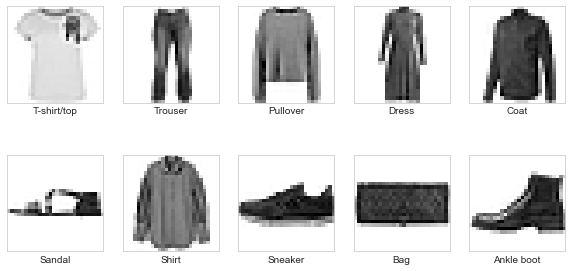

In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

labels_not_shown = {i for i in range(10)}
n = 0

plt.figure(figsize=(10,5))

while labels_not_shown:
    if int(y[n]) in labels_not_shown:
        plt.subplot(2,5,int(y[n]) + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[n].reshape(28, 28, 1), cmap=plt.cm.binary)
        plt.xlabel(class_names[int(y[n])])
        labels_not_shown.remove(int(y[n]))
    n += 1
plt.show()

### 1.2. Сделайте небольшой EDA (1 балл)

Посмотрите на баланс классов. В дальнейших домашках делайте EDA, когда считаете нужным, он нужен почти всегда, но оцениваться это уже не будет, если не будет указано иное. Делайте EDA, чтобы узнать что-то новое о данных!

In [7]:
labels, counts = np.unique(y, return_counts=True)
print("labels", labels)
print("counts", counts)

labels ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
counts [ 93 102  95 121  96  98 101  79 109 106]


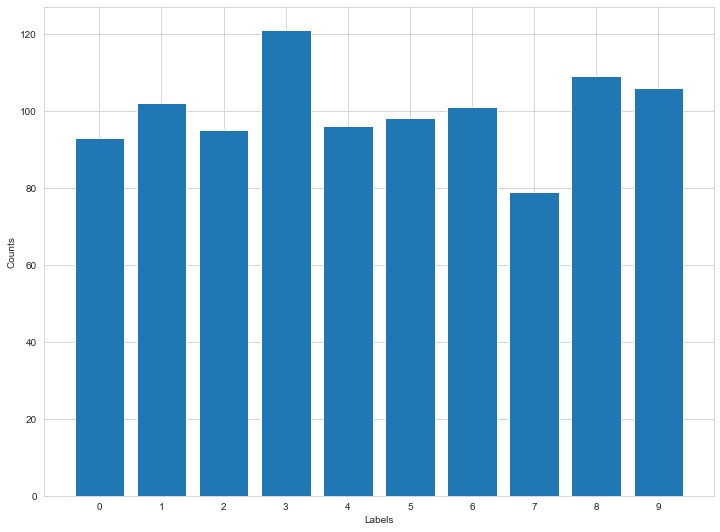

In [8]:
plt.bar(labels, counts) 
plt.xlabel('Labels') 
plt.ylabel('Counts')  
plt.show() 

### 1.3. Разделите данные на train и test (0.5 баллов)

Разделите данные на тренировочную и тестовую выборки, размеры тестовой выборки выберите сами. Здесь вам может помочь функция `train_test_split`

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 1.4. KNN для бинарной классификации (6 баллов)

Давайте возьмем для задачи бинарной классификации только объекты с метками классов 0 и 1.

In [10]:
y_bool_train = [True if i == "0" or i == "1" else False for i in y_train]
binary_train_X = X_train[y_bool_train]
binary_train_y = y_train[y_bool_train]

y_bool_test = [True if i == "0" or i == "1" else False for i in y_test]
binary_test_X = X_test[y_bool_test]
binary_test_y = y_test[y_bool_test]

In [11]:
X_test.shape

(300, 784)

In [12]:
X_train.shape

(700, 784)

И вот мы подготовили данные, но модели у нас пока что нет. В нескольких занятиях нашего курса вам придется самостоятельно реализовывать какие-то алгоритмы машинного обучения, а потом сравнивать их с готовыми библиотечными решениями. В остальных заданиях реализовывать алгоритмы будет не обязательно, но может быть полезно, поэтому часто это будут задания на дополнительные баллы, но главное не это, а понимание работы алгоритма после его реализации с нуля на простом numpy. Также это все потом можно оформить в виде репозитория ml_from_scratch и хвастаться перед друзьями.

In [13]:
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

### Настало время писать код!

В KNN нам нужно для каждого тестового примера найти расстояния до всех точек обучающей выборки. Допустим у нас 1000 примеров в train'е и 100 в test'е, тогда в итоге мы бы хотели получить матрицу попарных расстояний (например, размерностью 100 на 1000). Это можно сделать несколькими способами, и кому-то наверняка, в голову приходит идея с двумя вложенными циклами (надеюсь, что не больше:). Так можно делать, то можно и эффективнее. Вообще, в реальном KNN используется структура данных [k-d-tree](https://ru.wikipedia.org/wiki/K-d-%D0%B4%D0%B5%D1%80%D0%B5%D0%B2%D0%BE), которая позволяет производить поиск за log(N), а не за N, как будем делать мы (по сути это такое расширение бинарного поиска на многомерное пространство).

Вам нужно будет последовательно реализовать методы `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops` класса `KNN` в файле `knn.py`.

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание** Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)).

$d_{1}(\mathbf {p} ,\mathbf {q} )=\|\mathbf {p} -\mathbf {q} \|_{1}=\sum _{i=1}^{n}|p_{i}-q_{i}|$

В начале я буду иногда писать разные assert'ы, чтобы можно было проверить правильность реализации, в дальнейшем вам нужно будет их писать самим, если нужно будет проверять корректность каких-то вычислений.

In [14]:
# compute_distances_two_loops

dists = knn_classifier.compute_distances_two_loops(binary_test_X)
print(dists)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

[[34500. 36076. 35833. ... 47779. 31445. 36711.]
 [46939. 10509. 22940. ... 19738. 45854. 38678.]
 [26191. 44493. 43150. ... 47616. 21654. 28910.]
 ...
 [46046. 34274. 35261. ... 45325. 44161. 40115.]
 [47661. 21365. 28190. ... 37330. 45902. 33256.]
 [43462. 24202. 30357. ... 38029. 41277. 29831.]]


In [15]:
# compute_distances_one_loop
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
print(dists)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

[[34500. 36076. 35833. ... 47779. 31445. 36711.]
 [46939. 10509. 22940. ... 19738. 45854. 38678.]
 [26191. 44493. 43150. ... 47616. 21654. 28910.]
 ...
 [46046. 34274. 35261. ... 45325. 44161. 40115.]
 [47661. 21365. 28190. ... 37330. 45902. 33256.]
 [43462. 24202. 30357. ... 38029. 41277. 29831.]]


In [16]:
#compute_distances_no_loops
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
print(dists)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))


[[34500. 36076. 35833. ... 47779. 31445. 36711.]
 [46939. 10509. 22940. ... 19738. 45854. 38678.]
 [26191. 44493. 43150. ... 47616. 21654. 28910.]
 ...
 [46046. 34274. 35261. ... 45325. 44161. 40115.]
 [47661. 21365. 28190. ... 37330. 45902. 33256.]
 [43462. 24202. 30357. ... 38029. 41277. 29831.]]


Проверим скорость работы реализованных методов

In [17]:
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

81.4 ms ± 9.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
11.5 ms ± 972 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
59.8 ms ± 2.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Реализуем метод для предсказания меток класса

In [18]:
# predict_labels_binary in knn.py
prediction = knn_classifier.predict(binary_test_X)
print(prediction)
print(binary_test_y)

['0' '1' '0' '0' '0' '1' '1' '1' '1' '0' '1' '1' '0' '0' '0' '1' '0' '1'
 '0' '0' '1' '1' '0' '0' '1' '0' '1' '1' '0' '0' '0' '1' '1' '0' '1' '1'
 '0' '1' '0' '1' '1' '1' '0' '1' '0' '0' '1' '0' '1' '0' '0' '0' '1' '1']
['0' '1' '0' '0' '0' '1' '1' '1' '1' '0' '1' '1' '0' '0' '0' '1' '0' '1'
 '0' '0' '1' '1' '0' '0' '1' '0' '1' '1' '0' '0' '0' '1' '1' '0' '1' '1'
 '0' '1' '0' '1' '0' '1' '0' '1' '0' '0' '1' '0' '1' '0' '0' '0' '1' '1']


### Метрика

Теперь нужно реализовать несколько метрик для бинарной классификации. Не забудьте подумать о численной нестабильности (деление на 0).

In [19]:
# binary_classification_metrics in metrics.py

In [20]:
accuracy, precision, recall, f1 = binary_classification_metrics(prediction, binary_test_y)
print('Accuracy: %.3f' % accuracy)
print('Precision: %.3f' % precision)
print('Recall: %.3f' % recall)
print('F1 Score: %.3f' % f1)

Accuracy: 0.981
Precision: 0.963
Recall: 1.000
F1 Score: 0.981


Все ли хорошо с моделью? Можно проверить свою реализацию с функциями из библиотеки `sklearn`:

<img src="https://i.imgflip.com/406fu9.jpg" width="800" height="400">

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [22]:
y_pred = list(map(int, prediction))
y_true = list(map(int, binary_test_y))

print("accuracy_score", accuracy_score(y_true, y_pred))
print("precision", precision_score(y_true, y_pred, average='binary'))
print("recall_score", recall_score(y_true, y_pred, average='binary'))
print("f1_score", f1_score(y_true, y_pred, average='binary'))

accuracy_score 0.9814814814814815
precision 0.9629629629629629
recall_score 1.0
f1_score 0.9811320754716981


### Подбор оптимального k

Чтобы подрбрать оптимальное значение параметра k можно сделать следующее: задать область допустимых значений k, например, `[1, 3, 5, 10]`. Дальше для каждого k обучить модель на тренировочных данных, сделать предсказания на тестовых и посчитать какую-нибудь метрику (метрику выберите сами исходя из задачи, но постарайтесь обосновать выбор). В конце нужно посмотреть на зависимость метрики на train'е и test'е от k и выбрать подходящее значение.

Реализуйте функцию `choose_best_k` прямо в ноутбуке.

In [23]:
def find_best_k(X_train, y_train, X_test, y_test, params, metric):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation ("accuracy", "precision", "recall", "f1")
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    train_metrics, test_metrics = [], []
    for k in params:
        knn_classifier = KNNClassifier(k=k)
        knn_classifier.fit(X_train, y_train)
        prediction_test = knn_classifier.predict(X_test)
        prediction_train = knn_classifier.predict(X_train)
        accuracy_test, precision_test, recall_test, f1_test = binary_classification_metrics(prediction_test, y_test)
        accuracy_train, precision_train, recall_train, f1_train = binary_classification_metrics(prediction_train, y_train)
        if metric == "accuracy":
            train_metrics.append(accuracy_train)
            test_metrics.append(accuracy_test)
        elif metric == "precision":
            train_metrics.append(precision_train)
            test_metrics.append(precision_test)
        elif metric == "recall":
            train_metrics.append(recall_train)
            test_metrics.append(recall_test)
        elif metric == "f1":
            train_metrics.append(f1_train)
            test_metrics.append(f1_test)
            
    return train_metrics, test_metrics

In [24]:
params = [1, 2, 4, 5, 8, 10, 30]
train_metrics, test_metrics = find_best_k(binary_train_X, binary_train_y, binary_test_X, binary_test_y, params, "accuracy")

Accuracy - It is most used when all the classes are equally important. That is our case!

Precision - How many selected items are relevant? It is useful when the costs of False Positives is high.

Recall - How many relevant items are selected? It is important when the cost of False Negatives is high.

f1 is primarily used to compare the performance of two classifiers. 
Suppose that classifier A has a higher recall, and classifier B has higher precision. 
In this case, the F1-scores for both the classifiers can be used to determine which one produces better results.


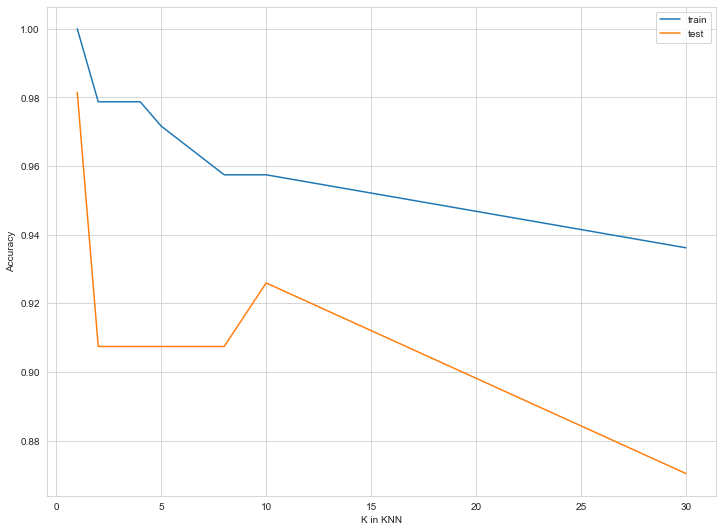

In [25]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("Accuracy");

На самом деле, это не самый лучший способ подбирать гиперпараметры, но способы получше мы рассмотрим в следующий раз, а пока что выберите оптимальное значение k, сделайте предсказания и посмотрите, насколько хорошо ваша модель предсказывает каждый из классов.

In [26]:
# k = 1 seems to be the best

knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
prediction = knn_classifier.predict(binary_test_X)
total_one, total_zero = 0, 0
tp = sum([1 for y_p, y_t in zip(prediction, binary_test_y) if y_p == "1" and y_t == "1"])
fp = sum([1 for y_p, y_t in zip(prediction, binary_test_y) if y_p == "1" and y_t == "0"])
tn = sum([1 for y_p, y_t in zip(prediction, binary_test_y) if y_p == "0" and y_t == "0"])
fn = sum([1 for y_p, y_t in zip(prediction, binary_test_y) if y_p == "0" and y_t == "1"])
print(f"TP: {tp}, FN: {fn}, TP/TP+FN: {tp/(tp + fn) if (tp + fn) != 0 else 'there is no 1'}")
print(f"TN: {tn}, FP: {fp}, TN/TN+FP: {tn/(tn + fp) if (tn + fp) != 0 else 'there is no 0'}") 

TP: 26, FN: 0, TP/TP+FN: 1.0
TN: 27, FP: 1, TN/TN+FP: 0.9642857142857143


In [27]:
cm = confusion_matrix(binary_test_y, prediction)

print(cm)

[[27  1]
 [ 0 26]]


### 1.5. Многоклассоввая классификация (2 балла)

Теперь нужно научиться предсказывать все 10 классов. Для этого в начале напишем соответствующий метод у нашего классификатора.

In [28]:
# predict_labels in knn.py
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(X_train, y_train)
predictions = knn_classifier.predict(X_test)
print(y_test)
print(predictions)

['7' '3' '9' '3' '5' '0' '5' '7' '1' '9' '4' '0' '9' '5' '4' '2' '9' '9'
 '9' '8' '8' '5' '5' '9' '2' '6' '8' '8' '9' '3' '2' '3' '0' '4' '8' '8'
 '4' '3' '2' '0' '5' '1' '2' '7' '9' '1' '7' '2' '1' '3' '5' '5' '1' '7'
 '0' '2' '2' '5' '7' '2' '3' '1' '6' '2' '6' '2' '6' '2' '3' '5' '4' '4'
 '1' '3' '9' '4' '3' '6' '6' '7' '5' '2' '6' '2' '0' '3' '8' '9' '2' '9'
 '6' '3' '4' '9' '6' '6' '6' '4' '3' '5' '2' '5' '2' '0' '5' '7' '7' '8'
 '5' '6' '2' '4' '7' '0' '8' '5' '9' '1' '4' '2' '0' '2' '2' '8' '6' '8'
 '5' '5' '8' '7' '2' '3' '4' '1' '8' '3' '0' '0' '9' '1' '2' '6' '4' '1'
 '2' '3' '8' '3' '9' '7' '8' '0' '7' '7' '6' '6' '6' '0' '4' '2' '1' '0'
 '6' '4' '9' '1' '4' '9' '1' '6' '8' '9' '3' '2' '5' '6' '9' '5' '8' '0'
 '2' '7' '3' '5' '3' '3' '3' '7' '2' '3' '3' '8' '4' '3' '2' '0' '0' '5'
 '7' '6' '1' '2' '1' '8' '3' '7' '9' '5' '4' '5' '8' '6' '2' '9' '4' '5'
 '0' '4' '8' '2' '1' '5' '8' '7' '1' '0' '5' '4' '8' '7' '1' '2' '5' '5'
 '2' '0' '4' '7' '6' '6' '3' '1' '0' '1' '6' '3' '7

Осталось реализовать метрику качества для многоклассовой классификации, для этого реализуйте функцию `multiclass_accuracy` в `metrics.py`.

In [29]:
accuracy = multiclass_accuracy(predictions, y_test)
accuracy

0.7233333333333334

Снова выберите оптимальное значение K как мы делали для бинарной классификации.

In [30]:
params = [1, 2, 4, 5, 8, 10, 30]
train_metrics, test_metrics = find_best_k(X_train, y_train, X_test, y_test, params, "accuracy")

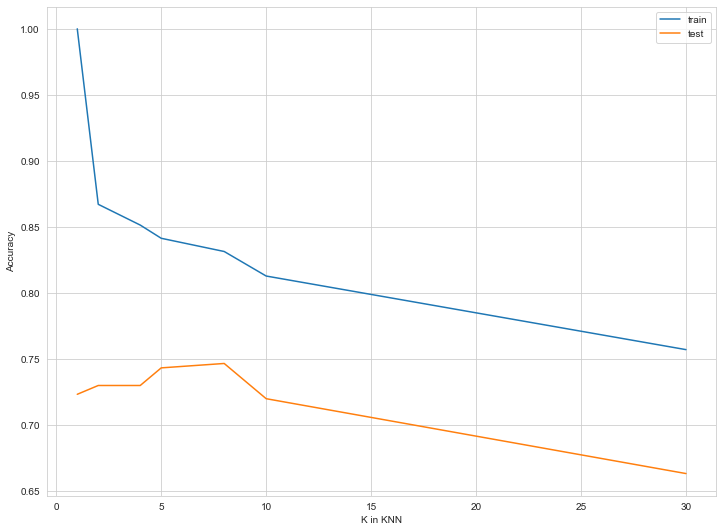

In [31]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("Accuracy");

As we can see, in train k=1 and in test k=5 is the best

## Задание 2. KNN на датасете diabetes (10 баллов)

Теперь попробуем применить KNN к задаче регрессии. Будем работать с [данными](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) о диабете. В этом задании будем использовать класс `KNeighborsRegressor` из библиотеки `sklearn`. Загрузим необходимые библиотеки:

In [32]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [33]:
X, y = load_diabetes(as_frame=True, return_X_y=True)

In [34]:
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


### 2.1. EDA (2 обязательных балла + 2 доп. балла за Pipeline)

Сделайте EDA, предобработайте данные так, как считаете нужным, нужна ли в данном случае стандартизация и почему? Не забудте, что если вы стандартизуете данные, то нужно считать среднее и сдандартное отклонение на тренировочной части и с помощью них трансформировать и train, и test (**если не поняли это предложение, то обязательно разберитесь**).

**Дополнительно**:
Попробуйте разобраться с [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), чтобы можно было создать класс, который сразу проводит стандартизацию и обучает модель (или делает предсказание). Пайплайны очень удобны, когда нужно применять различные методы предобработки данных (в том числе и к разным столбцам), а также они позволяют правильно интегрировать предобработку данных в различные классы для поиска наилучших гиперпараметров модели (например, `GridSearchCV`).

In [35]:
from sklearn.pipeline import Pipeline

In [36]:
X.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-3.634285e-16,1.308343e-16,-8.045349e-16,1.281655e-16,-8.835316e-17,1.327024e-16,-4.574646e-16,3.777301e-16,-3.830854e-16,-3.412882e-16
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123996e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260974e-01,-1.377672e-01
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665645e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324879e-02,-3.317903e-02
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670611e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947634e-03,-1.077698e-03
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564384e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243323e-02,2.791705e-02
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320442e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335990e-01,1.356118e-01


Standardization comes into the picture when features of the input data set have large differences between their ranges, or simply when they are measured in different units. That is not our case.

In [37]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
dtypes: float64(10)
memory usage: 34.7 KB


In [38]:
# Удалим повторяющиеся строки
X = X.drop_duplicates()

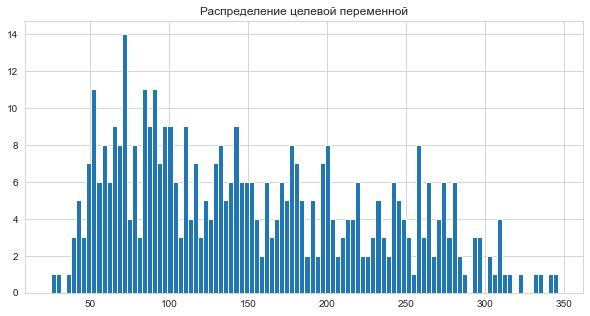

In [39]:
# Посмотрим распределение целевой переменной

plt.figure(figsize = (10, 5))

y.hist(bins=100)
plt.title('Распределение целевой переменной')
plt.show()

In [40]:
# Split the dataset to train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 2.2. Регрессионная модель (1 балл)

Создайте модель `KNeighborsRegressor`, обучите ее на треноровочных данных и сделайте предсказания.

In [41]:
model = KNeighborsRegressor(n_neighbors=3)
model.fit(X_train, y_train)
predictions = model.predict(X_test)


### 2.3. Метрики регресии (3 балла)

Реализуйте метрики $R^2$, MSE и  MAE в `metrics.py`. Примените их для оценки качества полученной модели. Все ли хорошо?

Напомню, что:

$R^2 = 1 - \frac{\sum_i^n{(y_i - \hat{y_i})^2}}{\sum_i^n{(y_i - \overline{y})^2}}$

$MSE = \frac{1}{n}\sum_i^n{(y_i - \hat{y_i})^2}$

$MAE = \frac{1}{n}\sum_i^n{|y_i - \hat{y_i}|}$

In [42]:
# r_squared, mse, mae in metrics.py
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("r2 from sklearn.metrics:", r2_score(y_test, predictions))
print("mae from sklearn.metrics:", mean_absolute_error(y_test, predictions))
print("mse from sklearn.metrics:", mean_squared_error(y_test, predictions))

mse = mse(predictions, y_test)
mae = mae(predictions, y_test)
r2 = r_squared(predictions, y_test)

print("mse:", mse)
print("mae:", mae)
print("r2:", r2)

"""
MAE (Mean absolute error) represents the difference between the original and predicted values extracted by averaged 
the absolute difference over the data set.

MSE (Mean Squared Error) represents the difference between the original and predicted values extracted by squared 
the average difference over the data set.

R-squared (Coefficient of determination) represents the coefficient of how well the values fit compared to the 
original values. The value from 0 to 1 interpreted as percentages. The higher the value is, the better the model is.
It can be negative.

The model is not so good.
"""



r2 from sklearn.metrics: 0.3213026740575181
mae from sklearn.metrics: 45.63659147869675
mse from sklearn.metrics: 3663.8170426065167
mse: 3663.8170426065158
mae: 45.63659147869674
r2: -0.3329535895332354


'\nA low R-Squared value means that the linear regression function line does not fit the data well.\n'

### 2.4. Подбор оптимального числа соседей (2 балла)

Мы почти дошли до конца. Теперь осталось при помощи реализованных нами метрик выбрать лучшее количество соседей для нашей модели.

!!! Обратите внимание на то, что значат наши метрики, для некоторых хорошо, когда они уменьшаются, для других наоборот.

In [46]:
def find_best_k_regression(X_train, y_train, X_test, y_test, params, metric):
    train_metrics, test_metrics = [], []
    for k in params:
        model = KNeighborsRegressor(n_neighbors=k)
        model.fit(X_train, y_train)
        prediction_test = model.predict(X_test)
        prediction_train = model.predict(X_train)
        if metric == "r2":
            train_metrics.append(r_squared(prediction_train, y_train))
            test_metrics.append(r_squared(prediction_test, y_test))
        elif metric == "mse":
            train_metrics.append(mse(prediction_train, y_train))
            test_metrics.append(mse(prediction_test, y_test))
        elif metric == "recall":
            train_metrics.append(mae(prediction_train, y_train))
            test_metrics.append(mae(prediction_test, y_test))
            
    return train_metrics, test_metrics

In [47]:
params = [1, 2, 4, 5, 8, 10, 30]
train_metrics, test_metrics = find_best_k_regression(X_train, y_train, X_test, y_test, params, "r2")

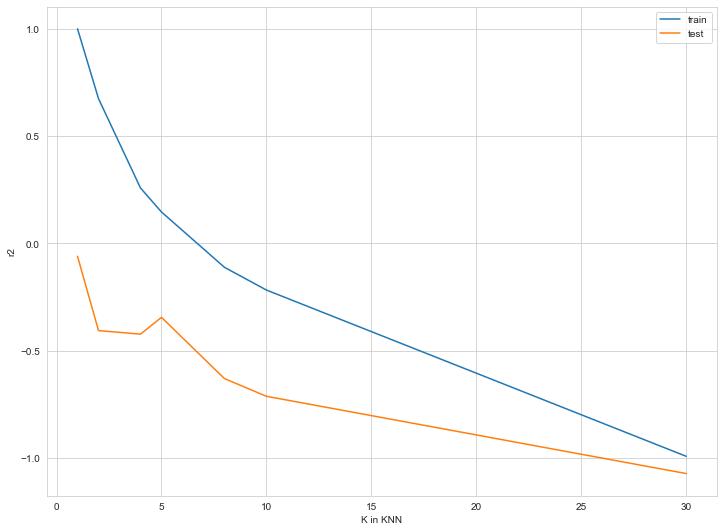

In [48]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("r2");